<center>
    <font size="6"><b>Introduction to Time Series Prediction</b></font>
    <br>
    <font size="3">(draft version)</font>
</center>

<br>

<center>
    <font size="3"><b>Piotr Lipiński</b></font>
    <br>
    Computational Intelligence Research Group, Institute of Computer Science, University of Wroclaw, Poland
    <br>
    lipinski@cs.uni.wroc.pl
</center>

### Abstract:

This notebook presents an introduction to time series prediction and illustrates the problem on the Airline Passengers dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

%matplotlib inline

In [160]:
import torch
from torch import nn
from IPython import display
import copy

## 1. Time Series Data

In [2]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])
df

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

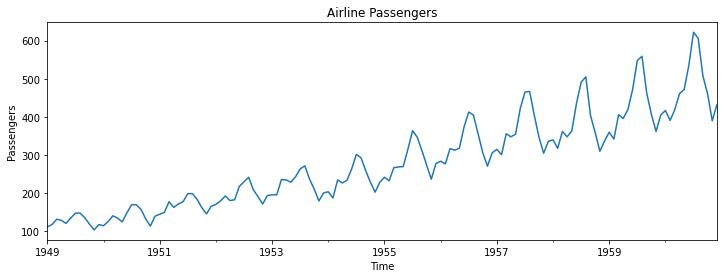

In [3]:
plt.figure(figsize=(12,4))
df['Passengers'].plot()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.show()

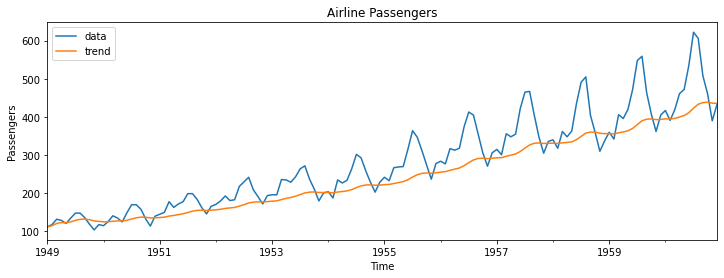

In [4]:
# df['trend'] = df['Passengers'].rolling(window=12, min_periods=1).mean()
# df['trend'] = df['Passengers'].ewm(span=12).mean()
df['trend'] = df['Passengers'].ewm(halflife=12).mean()

plt.figure(figsize=(12,4))
df['Passengers'].plot(label='data')
df['trend'].plot(label='trend')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

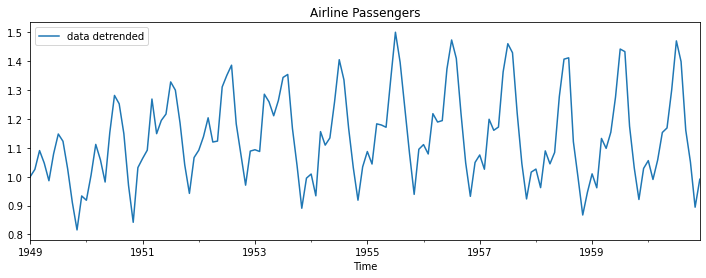

In [5]:
# df['detrended'] = df['Passengers'] - df['trend']
df['detrended'] = df['Passengers'] / df['trend']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

Month
1     1.045050
2     1.028700
3     1.166366
4     1.130612
5     1.131236
6     1.267675
7     1.384267
8     1.352408
9     1.167931
10    1.026496
11    0.904672
12    1.022858
Name: seasonality, dtype: float64

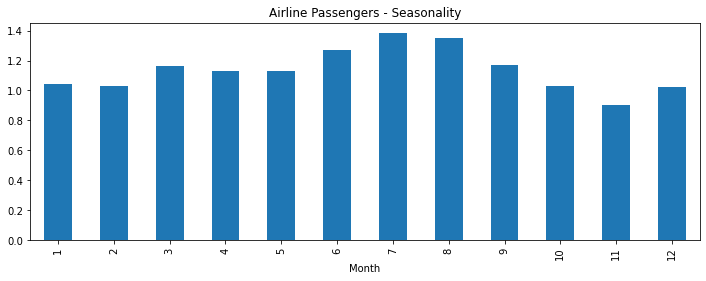

In [6]:
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
display(df_seasonality)

plt.figure(figsize=(12,4))
df_seasonality.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('')
plt.title('Airline Passengers - Seasonality')
plt.show()

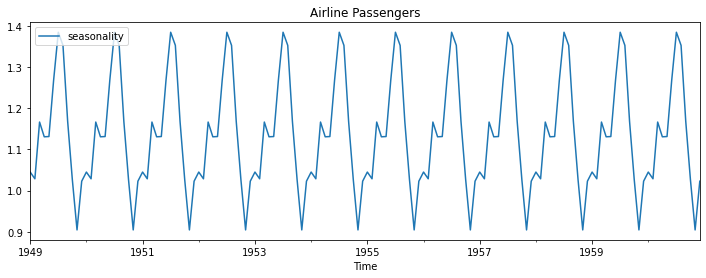

In [7]:
df = df.join(df_seasonality, how='left', on=df.index.month)

plt.figure(figsize=(12,4))
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

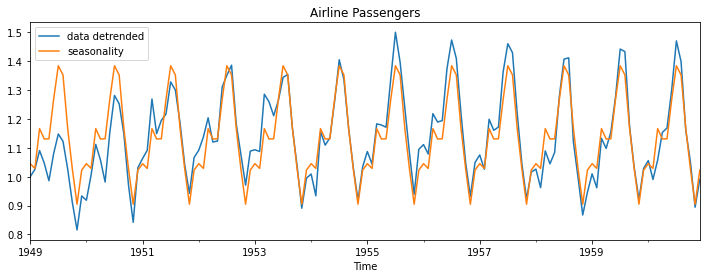

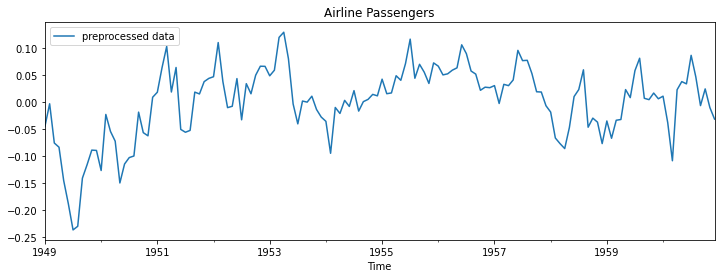

In [8]:
df['preprocessed'] = df['detrended'] - df['seasonality']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [18]:
preprocesedNp=np.array(df['preprocessed'])
trainData=preprocesedNp[:100]
testData=preposecedNp[100:]

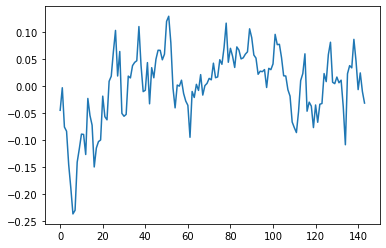

In [16]:
plt.plot(preprocesedNp)

In [27]:
testData.reshape((-1,1,1)).repeat(32,axis=1).shape

(44, 32, 1)

In [198]:
#zakładam, że dostaję tylko jeden szereg, ponieważ tyle mam w danych wejściowych
def wygenerujDodatkoweDane(orginalnySzeregTrain, koncowaLiczbaSzeregow=32, std=0.000001):
    szeregi=orginalnySzeregTrain.reshape((-1,1,1)).repeat(koncowaLiczbaSzeregow,axis=1)
    szeregi[:,1:,0]+=np.random.randn(*(szeregi[:,1:,0].shape))*std
    return szeregi

In [252]:
daneUczacePoszerzone=wygenerujDodatkoweDane(trainData, koncowaLiczbaSzeregow=1)

In [253]:
tDaneTrain=torch.Tensor(daneUczacePoszerzone).cuda()
tDaneTest=torch.Tensor(testData).reshape((-1,1,1)).cuda()

In [250]:
class siecRNN(nn.Module):
    def __init__(self, n_hid=2, czyLSTM=True):
        super().__init__()
        if czyLSTM:
            self.siecPamieci=nn.LSTM(input_size=1, hidden_size=n_hid, num_layers=1)
        else:
            self.siecPamieci=nn.GRU(input_size=1, hidden_size=n_hid, num_layers=1)
        self.siecWyjsciowa=nn.Linear(n_hid+1, 1)
        
    def forward(self, X):
        # out - (seq_len, batch, n_hid)
        out,_ = self.siecPamieci(X)
        inputs_and_H = torch.cat((X, out), dim=2)
        #print(out.shape)
        return self.siecWyjsciowa(inputs_and_H)

In [263]:
model=siecRNN().cuda()

optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

kroki=2000
bledy=[]
bledyTesty=[]
coIleKrokowWypisywacRezultaty=10
coIleCzyscic=500
kosztNajlepszego=1e8
najlepszyModel=None
for k in range(kroki):
    optimizer.zero_grad()
    W=model(tDaneTrain)
    koszt=torch.sum((tDaneTrain[1:,:,:]-W[:-1,:,:])**2)
    bledy.append((koszt.item()))
    koszt.backward()
    optimizer.step()
    if k%coIleKrokowWypisywacRezultaty==0:
        with torch.no_grad():
            W=model(tDaneTest)
            kosztTest=torch.sum((tDaneTest[1:,:,:]-W[:-1,:,:])**2)
        print(f"Krok: {k: 6}\t Train loss: {koszt.item():.5}\t Test loss {kosztTest.item():.5}")
        bledyTesty.append(kosztTest.item())
        if kosztTest.item()<kosztNajlepszego:
            kosztNajlepszego=kosztTest.item()
            najlepszyModel=copy.deepcopy(model)
    if k%coIleCzyscic==0:
        display.clear_output(wait=True)

Krok:   1510	 Train loss: 0.1525	 Test loss 0.067539
Krok:   1520	 Train loss: 0.15249	 Test loss 0.067542
Krok:   1530	 Train loss: 0.15248	 Test loss 0.067544
Krok:   1540	 Train loss: 0.15247	 Test loss 0.067547
Krok:   1550	 Train loss: 0.15246	 Test loss 0.06755
Krok:   1560	 Train loss: 0.15245	 Test loss 0.067552
Krok:   1570	 Train loss: 0.15244	 Test loss 0.067555
Krok:   1580	 Train loss: 0.15243	 Test loss 0.067557
Krok:   1590	 Train loss: 0.15242	 Test loss 0.06756
Krok:   1600	 Train loss: 0.15241	 Test loss 0.067562
Krok:   1610	 Train loss: 0.1524	 Test loss 0.067565
Krok:   1620	 Train loss: 0.15239	 Test loss 0.067567
Krok:   1630	 Train loss: 0.15238	 Test loss 0.06757
Krok:   1640	 Train loss: 0.15237	 Test loss 0.067572
Krok:   1650	 Train loss: 0.15236	 Test loss 0.067574
Krok:   1660	 Train loss: 0.15235	 Test loss 0.067577
Krok:   1670	 Train loss: 0.15234	 Test loss 0.067579
Krok:   1680	 Train loss: 0.15233	 Test loss 0.067581
Krok:   1690	 Train loss: 0.15232

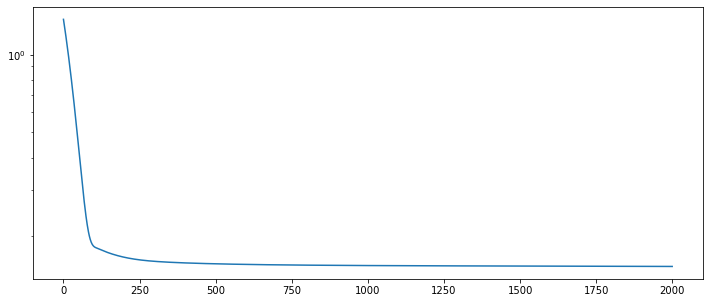

In [264]:
plt.gcf().set_size_inches((12,5))
plt.yscale("log")
plt.plot(bledy)

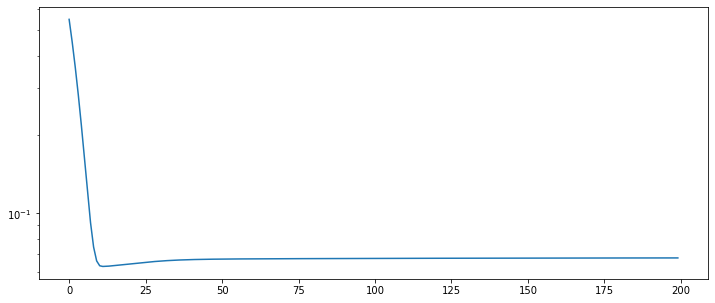

In [265]:
plt.gcf().set_size_inches((12,5))
plt.yscale("log")
plt.plot(bledyTesty)

In [266]:
model=najlepszyModel

In [267]:
tDaneTrain.shape

torch.Size([100, 1, 1])

/pio/scratch/1/i309016/miniconda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:581: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


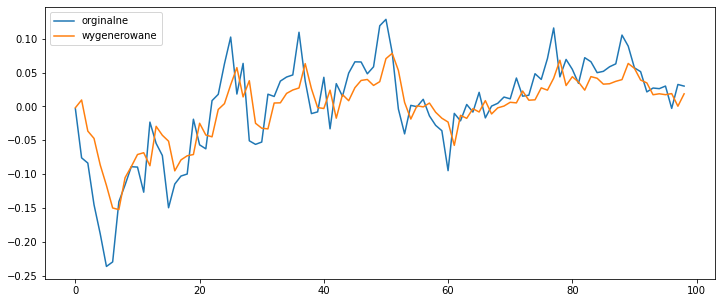

In [268]:
W=np.array(model(tDaneTrain).detach().cpu()[:,0,0].reshape(-1))
plt.gcf().set_size_inches((12,5))
plt.plot(trainData[1:], label="orginalne")
plt.plot(W[:-1], label="wygenerowane")
plt.legend()

In [269]:
predykcja=(df['seasonality'][1:100]+W[:-1])*df['trend']

print('MSE: %0.4f' % ((df['Passengers'] - predykcja)**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - predykcja).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - predykcja) / df['Passengers']).abs().mean())

MSE: 51.4056
MAE: 5.8266
MAPE: 0.0293


/pio/scratch/1/i309016/miniconda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:581: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


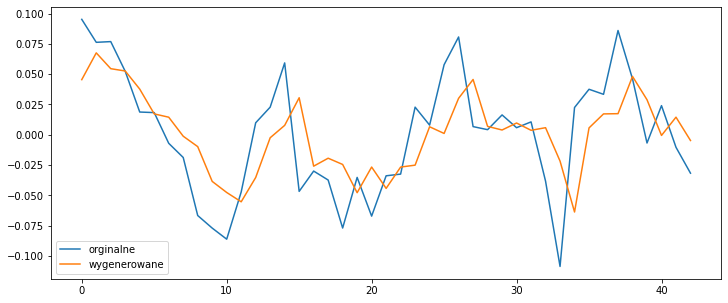

In [270]:
W=np.array(model(tDaneTest).detach().cpu().reshape(-1))
plt.gcf().set_size_inches((12,5))
plt.plot(testData[1:], label="orginalne")
plt.plot(W[:-1], label="wygenerowane")
plt.legend()

In [271]:
predykcja=(df['seasonality'][101:]+W[:-1])*df['trend'][101:]

print('MSE: %0.4f' % ((df['Passengers'][101:] - predykcja)**2).mean())
print('MAE: %0.4f' % (df['Passengers'][101:] - predykcja).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'][101:] - predykcja) / df['Passengers'][101:]).abs().mean())

MSE: 208.3002
MAE: 11.2479
MAPE: 0.0265


### GRU

In [295]:
model=siecRNN(n_hid=2, czyLSTM=False).cuda()

optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

kroki=10000
bledy=[]
bledyTesty=[]
coIleKrokowWypisywacRezultaty=20
coIleCzyscic=500
kosztNajlepszego=1e8
najlepszyModel=None
for k in range(kroki):
    optimizer.zero_grad()
    W=model(tDaneTrain)
    koszt=torch.sum((tDaneTrain[1:,:,:]-W[:-1,:,:])**2)
    bledy.append((koszt.item()))
    koszt.backward()
    optimizer.step()
    if k%coIleKrokowWypisywacRezultaty==0:
        with torch.no_grad():
            W=model(tDaneTest)
            kosztTest=torch.sum((tDaneTest[1:,:,:]-W[:-1,:,:])**2)
        print(f"Krok: {k: 6}\t Train loss: {koszt.item():.5}\t Test loss {kosztTest.item():.5}")
        bledyTesty.append(kosztTest.item())
        if kosztTest.item()<kosztNajlepszego:
            kosztNajlepszego=kosztTest.item()
            najlepszyModel=copy.deepcopy(model)
    if k%coIleCzyscic==0:
        display.clear_output(wait=True)

Krok:   1020	 Train loss: 0.15326	 Test loss 0.064724
Krok:   1040	 Train loss: 0.1531	 Test loss 0.064837
Krok:   1060	 Train loss: 0.15295	 Test loss 0.064942
Krok:   1080	 Train loss: 0.15281	 Test loss 0.065038
Krok:   1100	 Train loss: 0.15269	 Test loss 0.065126
Krok:   1120	 Train loss: 0.15257	 Test loss 0.065207
Krok:   1140	 Train loss: 0.15246	 Test loss 0.06528
Krok:   1160	 Train loss: 0.15236	 Test loss 0.065348
Krok:   1180	 Train loss: 0.15226	 Test loss 0.06541
Krok:   1200	 Train loss: 0.15217	 Test loss 0.065466
Krok:   1220	 Train loss: 0.15208	 Test loss 0.065518
Krok:   1240	 Train loss: 0.15199	 Test loss 0.065566
Krok:   1260	 Train loss: 0.15191	 Test loss 0.065609
Krok:   1280	 Train loss: 0.15183	 Test loss 0.06565
Krok:   1300	 Train loss: 0.15175	 Test loss 0.065687
Krok:   1320	 Train loss: 0.15167	 Test loss 0.065721
Krok:   1340	 Train loss: 0.15159	 Test loss 0.065753
Krok:   1360	 Train loss: 0.15152	 Test loss 0.065783


KeyboardInterrupt: 

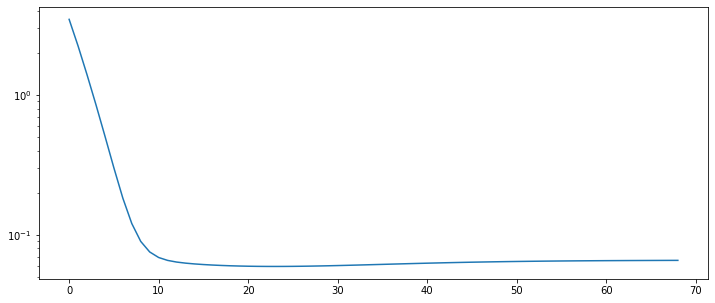

In [296]:
plt.gcf().set_size_inches((12,5))
plt.yscale("log")
plt.plot(bledyTesty)

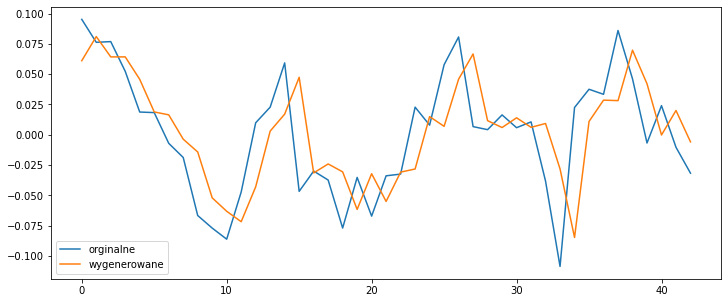

In [297]:
W=np.array(model(tDaneTest).detach().cpu().reshape(-1))
plt.gcf().set_size_inches((12,5))
plt.plot(testData[1:], label="orginalne")
plt.plot(W[:-1], label="wygenerowane")
plt.legend()

In [298]:
predykcja=(df['seasonality'][101:]+W[:-1])*df['trend'][101:]

print('MSE: %0.4f' % ((df['Passengers'][101:] - predykcja)**2).mean())
print('MAE: %0.4f' % (df['Passengers'][101:] - predykcja).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'][101:] - predykcja) / df['Passengers'][101:]).abs().mean())

MSE: 222.4855
MAE: 11.5496
MAPE: 0.0271
